In [12]:
import jax.numpy as np

from jax.config import config
from jax import jit, grad, random
from jax.experimental import optimizers
from jax.experimental import stax
from jax.experimental.stax import Dense, Relu, LogSoftmax, Sigmoid, Tanh
import numpy.random as npr
import jax
from tqdm.notebook import tqdm
import numpy as onp
import itertools
from functools import partial
import matplotlib.pyplot as plt

from SC_IPFP.utils import log_kde_pdf_per_point, silvermans_rule

In [93]:
@partial(jit, static_argnums=(2))
def knn_log_prob(xTrain, xTest, k=30, w=4):
    """
    Can use this as an alternative to  log_kde_pdf_per_point, very noisy
    
    Approximate density p(x) ~ 1/kNN(x, {y_i})^d 
    the ln p(x) ~ - d * log kNN(x, {y_i})
    
    where kNN(x, {y_i}) is the distance of the kth nearest neighbour
    
    source: http://faculty.washington.edu/yenchic/18W_425/Lec7_knn_basis.pdf
    
    loss is very noisy, and goes down very slowly and un-monotnically
    
    Theres a lot of studies about these estimates for KL and entropy by Barnabas Poczos
    they might have refinements on the kNNN part. 
    
    w is a windowing parameter to take the mean of the kNN distance going backwards
    to the k-w nearest neighbours, to make things less noisy.
    
    This also mode collapses just goes for a mode basically straight away. Its strange
    
    """
    k = int(k)
    w = int(min(w, k ))
    
    n, d = xTrain.shape
    
    sq_distances = -2 * np.dot(xTrain, xTest.T) + np.sum(xTest**2,axis=1) + np.sum(xTrain**2,axis=1)[:, np.newaxis]
    sq_distances = np.clip(sq_distances, 0, None)
    sq_distances =  np.sort(sq_distances,0) #distances sorted in axis 0
        
    sq_distance = np.mean(sq_distances[k-w: k,:])
#     print(sq_distance)
    return -(d * 0.5 * np.log(sq_distance))


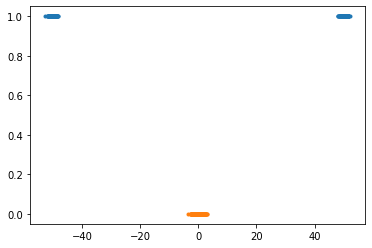

In [86]:
n = 900
n_2 = int(n / 3.0)

X1 = npr.randn(n).reshape(-1,1) + 0#50
X21 = 0.6 * npr.randn(450).reshape(-1,1) + 50
X22 =  0.6 * npr.randn(450).reshape(-1,1) - 50
# X23 =  0.6 * npr.randn(300).reshape(-1,1) - 30

X2 = np.concatenate((X22, X21), axis=0)

perm = onp.random.permutation(n)

X2 = X2[perm,:] 

plt.plot(X2.flatten(), [1] * n, '.')
plt.plot(X1.flatten(), [0] * n, '.')

In [78]:
def data_stream(X, batch_size = 200):
    rng =  npr.RandomState(0)

    
    num_batches = int(np.ceil(X.shape[0] / batch_size))
#     print(num_batches)

    num_train = X.shape[0]
    while True:
        perm = rng.permutation(num_train)
        for i in range(num_batches):
            batch_idx = perm[i * batch_size:(i + 1) * batch_size]
            yield X[batch_idx]
            
def create_network(dim, weights):
    model  = []
    for weight in weights:
        model.append(
            Dense(weight)
        )

        model.append(
            Relu
        )


    model.append(Dense(dim))

    init_random_params, predict = stax.serial(
       *model
    )
    return init_random_params, predict

In [79]:
def inner_loss(theta, batch):       
    batch_terminal_empirical = next(data_stream(X2))

    H = silvermans_rule(X2)
    
    Xt = b_forward(theta, batch)

    cross_entropy = -log_prob(Xt, batch_terminal_empirical, H)

    J = np.mean(cross_entropy)
    J = np.squeeze(J)

    return J

In [94]:

log_prob = log_kde_pdf_per_point
# log_prob = knn_log_prob

dim = 1

b_forward_init, b_forward = create_network(1, [20,20,20])
opt_init_f, opt_update_f, get_params_f = optimizers.adam(0.001)

rng = jax.random.PRNGKey(0)

_, init_params_f = b_forward_init(rng, (-1, dim))                                             
opt_state_f = opt_init_f(init_params_f)

batch_size = 200
num_complete_batches_f, leftover_f = divmod(X1.shape[0], batch_size)

batches_f = data_stream(X1, batch_size=batch_size)

loss_f = []

theta_f = get_params_f(opt_state_f)

for i in tqdm(range(1000)):
    itercount = itertools.count()

    for _ in range(num_complete_batches_f):
        batch_f =  next(batches_f)
        params = get_params_f(opt_state_f)
        gradient = grad(inner_loss)(params, batch_f)
        opt_state_f = opt_update_f(i, gradient, opt_state_f)
        
    params = get_params_f(opt_state_f)
    lossf = inner_loss(params, batch_f)
    print(f"loss f {lossf}")
    loss_f.append(lossf)

loss f 15.530492782592773
loss f 15.527521133422852
loss f 15.524386405944824
loss f 15.519002914428711
loss f 15.504644393920898
loss f 15.507845878601074
loss f 15.492761611938477
loss f 15.475907325744629
loss f 15.468039512634277
loss f 15.464555740356445
loss f 15.43324089050293
loss f 15.417580604553223
loss f 15.405126571655273
loss f 15.378874778747559
loss f 15.308034896850586
loss f 15.295222282409668
loss f 15.241835594177246
loss f 15.18121337890625
loss f 15.191235542297363
loss f 15.071163177490234
loss f 14.997795104980469
loss f 15.000572204589844
loss f 14.858769416809082
loss f 14.86082649230957
loss f 14.889301300048828
loss f 14.709651947021484
loss f 14.65867805480957
loss f 14.641879081726074
loss f 14.4970064163208
loss f 14.503199577331543
loss f 14.31207275390625
loss f 14.232763290405273
loss f 14.145071029663086
loss f 14.029675483703613
loss f 13.765273094177246
loss f 13.76925277709961
loss f 13.63304328918457
loss f 13.327478408813477
loss f 13.42627239227

loss f 3.8758575916290283
loss f 3.698760747909546
loss f 3.3934555053710938
loss f 3.4165239334106445
loss f 3.503993034362793
loss f 3.4935126304626465
loss f 3.7707467079162598
loss f 3.674696445465088
loss f 3.5553159713745117
loss f 4.088072299957275
loss f 3.6442596912384033
loss f 3.5318496227264404
loss f 3.4537720680236816
loss f 3.4875071048736572
loss f 3.575120449066162
loss f 3.613823652267456
loss f 3.6193172931671143
loss f 3.5238006114959717
loss f 3.458968162536621
loss f 3.6667187213897705
loss f 3.501157283782959
loss f 3.478947401046753
loss f 3.657040596008301
loss f 3.412769079208374
loss f 3.3213324546813965
loss f 3.8104686737060547
loss f 3.687563180923462
loss f 3.478290319442749
loss f 3.4671621322631836
loss f 3.4282944202423096
loss f 3.310718059539795
loss f 3.4481515884399414
loss f 3.520939350128174
loss f 3.398287773132324
loss f 3.753685712814331
loss f 3.641719341278076
loss f 3.3523905277252197
loss f 3.358325719833374
loss f 3.4348459243774414
loss 

loss f 2.8117055892944336
loss f 2.8799283504486084
loss f 2.881263494491577
loss f 2.7636568546295166
loss f 2.807818651199341
loss f 2.913879632949829
loss f 2.825417995452881
loss f 2.8850784301757812
loss f 2.824714422225952
loss f 2.8882105350494385
loss f 2.7949347496032715
loss f 2.9561779499053955
loss f 2.9024698734283447
loss f 3.060981035232544
loss f 2.8570756912231445
loss f 2.8454675674438477
loss f 2.8270456790924072
loss f 2.834873914718628
loss f 2.8163251876831055
loss f 2.812509059906006
loss f 2.852020502090454
loss f 2.8424646854400635
loss f 2.797991991043091
loss f 2.854616403579712
loss f 2.8522303104400635
loss f 2.854733943939209
loss f 2.841229200363159
loss f 2.823478937149048
loss f 3.161155939102173
loss f 2.8037753105163574
loss f 2.882326602935791
loss f 2.764646053314209
loss f 2.8630483150482178
loss f 2.8232967853546143
loss f 2.746253252029419
loss f 2.8051345348358154
loss f 2.8162286281585693
loss f 2.7917466163635254
loss f 2.862921714782715
loss 

loss f 2.772646188735962
loss f 2.751509666442871
loss f 2.873889446258545
loss f 2.7772915363311768
loss f 2.772995710372925
loss f 2.8113739490509033
loss f 2.797537326812744
loss f 2.7526700496673584
loss f 2.747957706451416
loss f 2.745436429977417
loss f 2.7451257705688477
loss f 2.7780601978302
loss f 2.7527642250061035
loss f 2.809368848800659
loss f 2.8007802963256836
loss f 2.762411594390869
loss f 2.742532968521118
loss f 2.763571262359619
loss f 2.758094549179077
loss f 2.7881412506103516
loss f 2.76487398147583
loss f 2.825476884841919
loss f 2.758308172225952
loss f 2.7867844104766846
loss f 2.782728910446167
loss f 2.7965025901794434
loss f 2.792120933532715
loss f 2.821599006652832
loss f 2.8157925605773926
loss f 2.774777889251709
loss f 2.833439588546753
loss f 2.805830717086792
loss f 2.8093154430389404



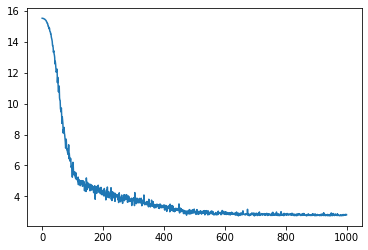

In [95]:
plt.plot(loss_f)

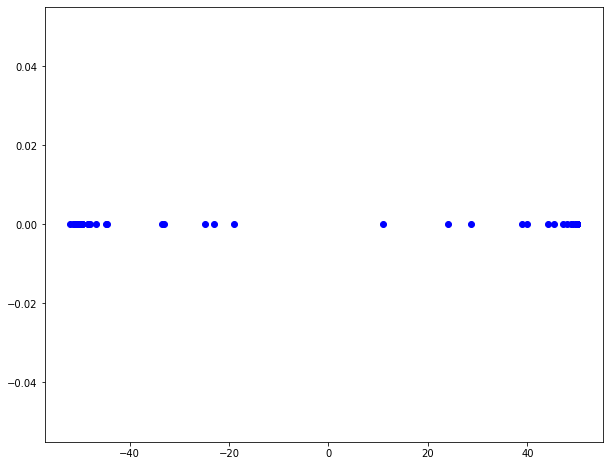

In [96]:
fig, axs = plt.subplots(1,  sharey=False, figsize=(10,8))


X =  b_forward(params, X1)
    
axs.plot(X.flatten(), [0] * n , 'ob', )